https://github.com/adhok/Image-Upscaling-Using-Tensorflow

In [2]:
from google.colab import files
uploaded = files.upload()

Saving blur.jpg to blur.jpg


In [0]:
import itertools
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io,transform
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7
from skimage.viewer import ImageViewer

Loading the Image


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


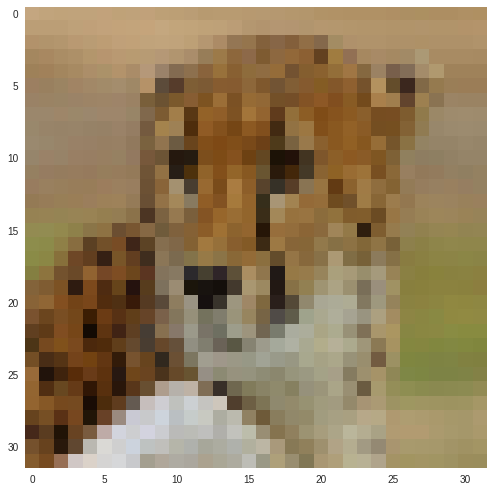

In [12]:
# The train image will be scaled to a square of dimensions `train_size x train_size`
train_size = 32
# When generating the image, the network will generate for an image of
# size `test_size x test_size`
test_size = 2048
# Path to load the image you want upscaled
image_path = 'blur.jpg'

if not image_path:
    print('Please specify an image for training the network')
else:
    image = transform.resize(io.imread(image_path), (train_size, train_size))
    # Just a quick line to get rid of the alpha channel if it exists
    # (e.g. for transparent png files)
    image = image if len(image.shape) < 3 or image.shape[2] == 3 else image[:,:,:3]
    io.imshow(image)
    plt.grid(None)
    plt.show()

Multi-Layer Perceptrons
To un-blur our image we will be using the multilayered perceptron model. This is also called a neural network.

Input Matrix


In [0]:
X = tf.placeholder("float32",(None,2))

In [0]:
def model(X, w):
    h1 = tf.nn.tanh(tf.matmul(X, w['h1']))
    h2 = tf.nn.tanh(tf.matmul(h1, w['h2']))
    h3 = tf.nn.tanh(tf.matmul(h2, w['h3']))
    h4 = tf.nn.tanh(tf.matmul(h3, w['h4']))
    h5 = tf.nn.tanh(tf.matmul(h4, w['h4']))
    h6 = tf.nn.tanh(tf.matmul(h5, w['h4']))
    h7 = tf.nn.tanh(tf.matmul(h6, w['h4']))
    h8 = tf.nn.tanh(tf.matmul(h7, w['h4']))    
    return tf.nn.sigmoid(tf.matmul(h8, w['out']))

In [7]:
def init_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

# (None, None) refers to (batch_size, n_colors)
Y = tf.placeholder("float32", (None, None))

w = {
  'h1': init_weights([2, 20]),
  'h2': init_weights([20, 20]),
  'h3': init_weights([20, 20]),
  'h4': init_weights([20, 20]),
  'h5': init_weights([20, 20]),
  'h6': init_weights([20, 20]),
  'h7': init_weights([20, 20]),
  'h8': init_weights([20, 20]),
  'out': init_weights([20, 3]),
}

out = model(X, w)

Instructions for updating:
Colocations handled automatically by placer.


Training
Will be using the least squares metric. Adam optimizers to minimize this loss.

In [0]:
cost = tf.reduce_mean(tf.squared_difference(out, Y))
train_op = tf.train.AdamOptimizer().minimize(cost)

In [9]:
# Feel free to adjust the number of epochs to your liking.
n_epochs = 5e+4

# Create function to generate a coordinate matrix (i.e. matrix of normalised coordinates)
# Pardon my lambda 
generate_coord = lambda size: (
    np.array(list(itertools.product(np.linspace(0,1,size),np.linspace(0,1,size)))).reshape(size ** 2, 2))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Training data
    x = generate_coord(train_size)
    # Labels
    reshaped_image = np.array(image.reshape(train_size ** 2, -1))
    
    for epoch in range(int(n_epochs + 1)):
        _, c = sess.run([train_op, cost], feed_dict={X: x, Y: reshaped_image})
        
        # Print progress
        if epoch % (n_epochs/10) == 0:
            print('{:0.0%} \t Loss: {}'.format(epoch/n_epochs, c).expandtabs(7))
    
    # Generate
    new_image = sess.run(out, feed_dict={X: generate_coord(test_size)})


0%      Loss: 0.034303005784749985
10%     Loss: 0.005784548819065094
20%     Loss: 0.004761651623994112
30%     Loss: 0.004172046203166246
40%     Loss: 0.0036886020097881556
50%     Loss: 0.003247477812692523
60%     Loss: 0.0030985993798822165
70%     Loss: 0.0029484659899026155
80%     Loss: 0.0028423266485333443
90%     Loss: 0.002696867799386382
100%    Loss: 0.0026041828095912933


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


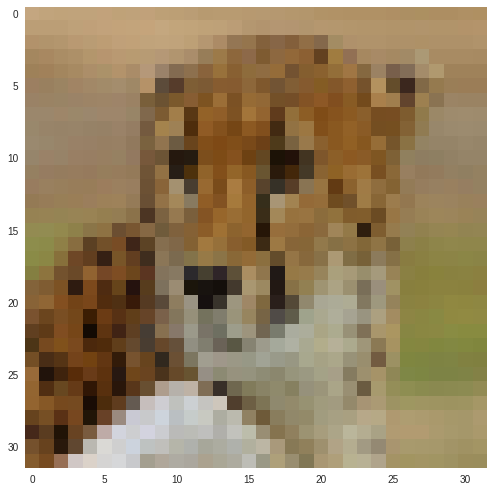

In [16]:
io.imshow(image)
plt.grid(None)
plt.show()

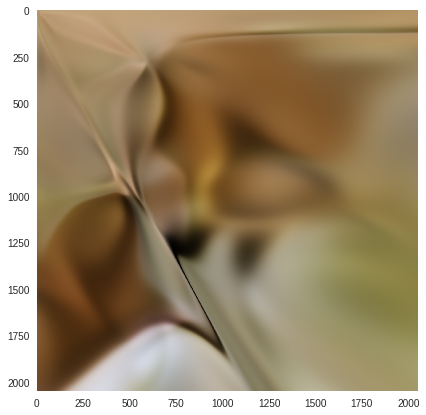

In [11]:
plt.imshow(new_image.reshape(test_size, test_size, -1))
plt.grid(None)
plt.show()